In [89]:
# Run this in a notebook cell to install a stable version of pyarrow
# import sys
# import subprocess

# # Uninstall the current broken version
# subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "pyarrow", "-y"])

# # Install a stable version (16.1.0)
# subprocess.check_call([sys.executable, "-m", "pip", "install", "pyarrow==16.1.0"])

In [90]:
import pandas as pd
import numpy as np
import re
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [91]:
df = pd.read_csv('property_listing_data_in_Bangladesh.csv')

In [92]:
# Count missing values in each column
missing_values = df.isnull().sum()

# Display the result
print(missing_values)

title          0
beds           0
bath           0
area           0
address        0
type           0
purpose        0
flooPlan       1
url            0
lastUpdated    0
price          0
dtype: int64


In [93]:
# -------------------------------------------------
# 1. PREMIUM AREA
# -------------------------------------------------
premium_areas = [
    'Gulshan', 'Banani', 'Baridhara', 'Uttara Sector 13',
    'Dhanmondi', 'Mirpur DOHS', 'Mohakhali DOHS',
    'Nasirabad Properties', 'Rajuk Uttara Apartment Project'
]

df['is_premium_area'] = df['title'].apply(
    lambda t: int(any(area in t for area in premium_areas))
)

# -------------------------------------------------
# 2. CONDITION (medium‑value predictor)
# -------------------------------------------------
condition_keywords = [
    'Strongly Structured', 'Tastefully Designed', 'Strongly Constructed',
    'Well-Constructed', 'Elegant', 'Spacious', 'Excellent',
    'Marvelous', 'Perfect', 'Smartly Priced'
]

df['is_high_condition'] = df['title'].apply(
    lambda t: int(any(word in t for word in condition_keywords))
)

# -------------------------------------------------
# 3. FURNISHED (high‑value indicator)
# -------------------------------------------------
df['is_fully_furnished'] = df['title'].str.contains(
    'Fully Furnished', case=False, na=False
).astype(int)

# -------------------------------------------------
# 5. LUXURY & VIEW (luxury indicator)
# -------------------------------------------------
def is_luxury(title: str) -> int:
    """Return 1 if any luxury‑related keyword appears in the title."""
    luxury_keywords = [
        'Open Sky View',
        'Penthouse', 
        'Sky View'
    ]
    return int(any(word in title for word in luxury_keywords))

df['is_luxury'] = df['title'].apply(is_luxury)

# -------------------------------------------------
# Sample output
# -------------------------------------------------
print("Sample of extracted features:")
print(df[['title',
          'is_premium_area',
          'is_high_condition',
          'is_fully_furnished',
          'is_luxury',
          'beds']].head(10))

Sample of extracted features:
                                               title  is_premium_area  \
0  Eminent Apartment Of 2200 Sq Ft Is Vacant For ...                0   
1  Apartment Ready To Rent In South Khulshi, Near...                0   
2  Smartly priced 1950 SQ FT apartment, that you ...                0   
3  2000 Sq Ft Residential Apartment Is Up For Ren...                0   
4  Strongly Structured This 1650 Sq. ft Apartment...                0   
5  A nice residential flat of 3400 SQ FT, for ren...                1   
6  1600 Square Feet Apartment With Amazing Rooms ...                0   
7  Let Us Help You To Rent This 1250 Sq Ft Apartm...                0   
8  An Extensive Apartment Of 2150 Sq Ft Is Vacant...                0   
9  A well-constructed 1250 SQ FT apartment is rea...                0   

   is_high_condition  is_fully_furnished  is_luxury beds  
0                  0                   0          0    3  
1                  0                   0        

In [94]:
amenities_keywords = {
    'has_lift': ['lift', 'elevator'],
    'has_generator': ['generator', 'power backup', 'backup'],
    'has_gas': ['gas', 'gas line'],
    'has_security': ['security', 'guard', 'cctv', 'cc camera'],
    'has_parking': ['parking', 'garage']
}

for feature, keywords in amenities_keywords.items():
    pattern = '|'.join(keywords)
    df[feature] = df['title'].str.contains(pattern, case=False, na=False).astype(int)

print(df[['title', 'has_lift', 'has_gas', 'has_generator']].head())

                                               title  has_lift  has_gas  \
0  Eminent Apartment Of 2200 Sq Ft Is Vacant For ...         0        0   
1  Apartment Ready To Rent In South Khulshi, Near...         0        0   
2  Smartly priced 1950 SQ FT apartment, that you ...         0        0   
3  2000 Sq Ft Residential Apartment Is Up For Ren...         0        0   
4  Strongly Structured This 1650 Sq. ft Apartment...         0        0   

   has_generator  
0              0  
1              0  
2              0  
3              0  
4              0  


In [95]:
# # assume df is your DataFrame
# unique_addresses = df['address'].dropna().unique()   # remove NaNs if any

# # ── Print to console ─────────────────────────────────────
# for addr in unique_addresses:
#     print(addr)

# # ── Save to a text file (one address per line) ─────────────────────
# with open('unique_addresses.txt', 'w', encoding='utf-8') as f:
#     for addr in unique_addresses:
#         f.write(f"{addr}\n")

In [96]:
df['area'] = df['area'].str.replace(',', '', regex=False)
df['area'] = df['area'].str.replace(' sqft', '', regex=False)
df['area'] = df['area'].astype(float)

In [97]:
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')
df['bath'] = pd.to_numeric(df['bath'], errors='coerce')

In [98]:
median_beds = df['beds'].median()
median_bath = df['bath'].median()

In [99]:
df['beds'] = df['beds'].fillna(median_beds)
df['bath'] = df['bath'].fillna(median_bath)

In [100]:
df['baths_per_bed'] = df['bath'] / (df['beds'] + 1e-6)
df['beds_minus_baths'] = df['beds'] - df['bath']
df['total_rooms'] = df['beds'] + df['bath']
df['beds_times_bath'] = df['beds'] * df['bath']

In [101]:
print(df.isnull().sum())

title                 0
beds                  0
bath                  0
area                  0
address               0
type                  0
purpose               0
flooPlan              1
url                   0
lastUpdated           0
price                 0
is_premium_area       0
is_high_condition     0
is_fully_furnished    0
is_luxury             0
has_lift              0
has_generator         0
has_gas               0
has_security          0
has_parking           0
baths_per_bed         0
beds_minus_baths      0
total_rooms           0
beds_times_bath       0
dtype: int64


In [102]:
df.columns

Index(['title', 'beds', 'bath', 'area', 'address', 'type', 'purpose',
       'flooPlan', 'url', 'lastUpdated', 'price', 'is_premium_area',
       'is_high_condition', 'is_fully_furnished', 'is_luxury', 'has_lift',
       'has_generator', 'has_gas', 'has_security', 'has_parking',
       'baths_per_bed', 'beds_minus_baths', 'total_rooms', 'beds_times_bath'],
      dtype='object')

In [103]:
# 4. Clean Price & Area
def convert_price_to_number(price):
    """
    Converts a price string (potentially with mixed units like Lakh/Thousand/Crore)
    into a single float value.
    """
    # 1. Handle if input is already a number (int or float)
    if isinstance(price, (int, float)):
        return float(price)
    
    # 2. Handle non-string inputs (e.g., NaN or None)
    if not isinstance(price, str):
        return 0.0
        
    # 3. Normalize string: lowercase and remove commas
    price = price.lower().replace(',', '')
    
    # 4. Define multipliers (Added 'Crore' as it is common in Bangladesh)
    multipliers = {
        'crore': 10000000,
        'lakh': 100000,
        'million': 1000000,
        'thousand': 1000,
        'k': 1000
    }
    
    # 5. Regex Pattern:
    # (\d+(?:\.\d+)?) -> Matches integers or decimals (Group 1)
    # \s*             -> Matches optional whitespace
    # (crore|lakh|...)? -> Matches optional unit keywords (Group 2)
    pattern = re.compile(r'(\d+(?:\.\d+)?)\s*(crore|lakh|million|thousand|k)?')
    
    total = 0.0
    matches = pattern.findall(price)
    
    for num_str, unit in matches:
        value = float(num_str)
        if unit in multipliers:
            total += value * multipliers[unit]
        else:
            # If no unit is specified, assume it is in the base currency (e.g. Taka)
            total += value
            
    return total

df['price'] = df['price'].apply(convert_price_to_number)

In [104]:
df = df[df['price'] > 0] 

MAX_AREA = 4000
df = df[df['area'] < MAX_AREA]

MAX_PRICE = 200000
df = df[df['price'] < MAX_PRICE]

In [105]:
print(f"Original Dataset Size: 7557")
print(f"Filtered Dataset Size: {len(df)}")
print(f"Removed outliers: {7557 - len(df)} rows")

Original Dataset Size: 7557
Filtered Dataset Size: 7379
Removed outliers: 178 rows


In [106]:
cols_to_drop = ['title', 'purpose', 'flooPlan', 'url', 'lastUpdated']
df = df.drop(cols_to_drop, axis=1)

In [107]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [108]:
X = df.drop('price', axis=1)
y = df['price']
y_log = np.log1p(y)

In [109]:
# 7. Train/Val/Test Split (60/20/20)
X_train, X_rem, y_train_log, y_rem_log = train_test_split(
    X, y_log, 
    train_size=0.6, 
    random_state=42
)

X_val, X_test, y_val_log, y_test_log = train_test_split(
    X_rem, y_rem_log, 
    test_size=0.5, 
    random_state=42
)

In [110]:
#Target Encoding Address (Strict Train-Only Logic)
train_combined = X_train.copy()
train_combined['price'] = np.expm1(y_train_log) # Convert back to actual price for grouping
mean_map = train_combined.groupby('address')['price'].mean()
global_mean = train_combined['price'].mean()

def encode_address(data, mean_map, global_mean):
    data_copy = data.copy()
    data_copy['address_encoded'] = data_copy['address'].map(mean_map)
    data_copy['address_encoded'] = data_copy['address_encoded'].fillna(global_mean)
    data_copy.drop('address', axis=1, inplace=True)
    return data_copy

X_train_enc = encode_address(X_train, mean_map, global_mean)
X_val_enc   = encode_address(X_val, mean_map, global_mean)
X_test_enc  = encode_address(X_test, mean_map, global_mean)

In [111]:
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',          # Optimizing for Root Mean Squared Error
    num_leaves=31,          # Controls model complexity (default 31)
    learning_rate=0.05,     # Step size shrinkage
    n_estimators=1000,      # Number of boosting rounds (we will use early stopping)
    random_state=42,
    verbose=-1              # Suppress info logs
)

In [112]:
model.fit(
    X_train_enc, 
    y_train_log,
    eval_set=[(X_val_enc, y_val_log)],
    callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [113]:
y_train_pred_log = model.predict(X_train_enc)
y_val_pred_log = model.predict(X_val_enc)

# Convert back from Log to Actual Prices for evaluation
y_train_pred = np.expm1(y_train_pred_log)
y_val_pred = np.expm1(y_val_pred_log)
y_train_actual = np.expm1(y_train_log)
y_val_actual = np.expm1(y_val_log)

In [114]:
train_mse = mean_squared_error(y_train_actual, y_train_pred)
val_mse = mean_squared_error(y_val_actual, y_val_pred)

train_rmse = np.sqrt(train_mse)
val_rmse = np.sqrt(val_mse)
avg_price = np.mean(y_train_actual)

train_error_pct = (train_rmse / avg_price) * 100
val_error_pct = (val_rmse / avg_price) * 100

print("="*40)
print("LightGBM Model Performance")
print("="*40)
print(f"Average House Price: {avg_price:,.2f}")
print(f"Training RMSE: {train_rmse:,.2f} ({train_error_pct:.2f}%)")
print(f"Validation RMSE: {val_rmse:,.2f} ({val_error_pct:.2f}%)")

LightGBM Model Performance
Average House Price: 26,811.24
Training RMSE: 7,699.97 (28.72%)
Validation RMSE: 8,210.02 (30.62%)


In [115]:
print("\n--- Model Diagnosis ---")
if val_error_pct > train_error_pct * 1.5:
    print("Status: Potential Overfitting (Consider reducing num_leaves or increasing min_data_in_leaf)")
elif val_error_pct > 50:
    print("Status: Underfitting (Consider increasing learning rate or n_estimators)")
else:
    print("Status: Good Fit")


--- Model Diagnosis ---
Status: Good Fit



--- Top 10 Important Features ---
              Feature  Importance
18    address_encoded        2297
2                area        1646
12      baths_per_bed         149
14        total_rooms         145
1                bath         128
0                beds          79
3     is_premium_area          54
4   is_high_condition          28
15    beds_times_bath          23
13   beds_minus_baths          11


C:\Users\ahsbd\AppData\Local\Temp\ipykernel_6272\587998456.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df.head(15), palette='viridis')


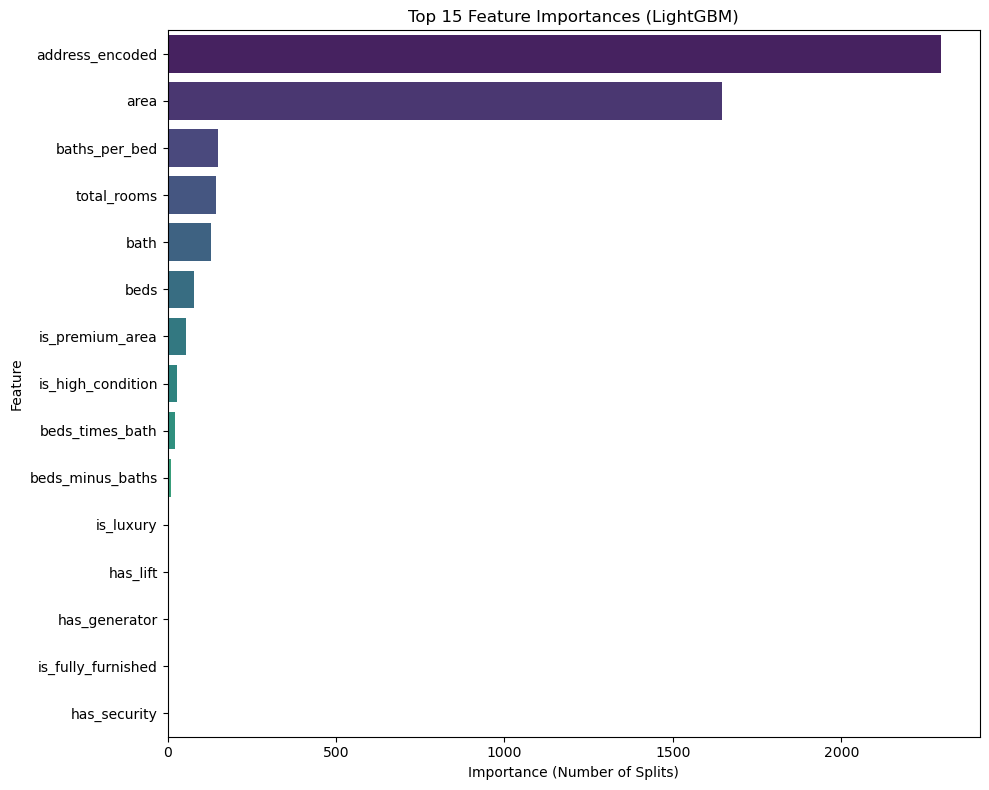

In [116]:
importance = model.feature_importances_
feature_names = X_train_enc.columns

# Create a DataFrame to hold the results
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Display top 10 features
print("\n--- Top 10 Important Features ---")
print(fi_df.head(10))

# Plot Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (LightGBM)')
plt.xlabel('Importance (Number of Splits)')
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.tight_layout()
plt.show()